In [ ]:
# We will detect the solar disk, and we will remove those.

solar_image_array max 255
solar_image_array min 0


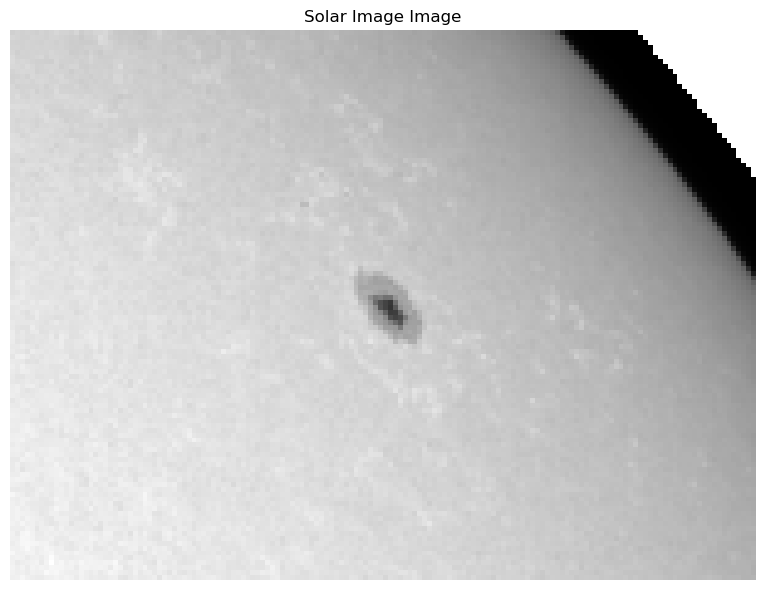

In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Great article about the hough transform using open cv, cv2
# https://pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/

# https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert
# Load and convert images to grayscale
solar_image = Image.open("../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png").convert("L")

# Convert the images to NumPy arrays
solar_image_array = np.array(solar_image, dtype=np.uint8)

# Print min and max values for coin image
print("solar_image_array max", solar_image_array.max())
print("solar_image_array min", solar_image_array.min())

# Create a figure with 1 row and 2 columns for the images
fig, axs = plt.subplots(figsize=(12, 6))

# Display the first image with a title on top
axs.imshow(solar_image_array, cmap='gray')
axs.set_title("Solar Image Image")
axs.axis('off')  # Turn off axis labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Circle at (113, 39) with radius 38 has 60.0 votes
Circle at (60, 79) with radius 93 has 56.0 votes
Circle at (148, 0) with radius 31 has 36.0 votes
Circle at (135, 71) with radius 59 has 32.0 votes
Circle at (77, 2) with radius 57 has 32.0 votes
Circle at (141, 102) with radius 81 has 29.0 votes


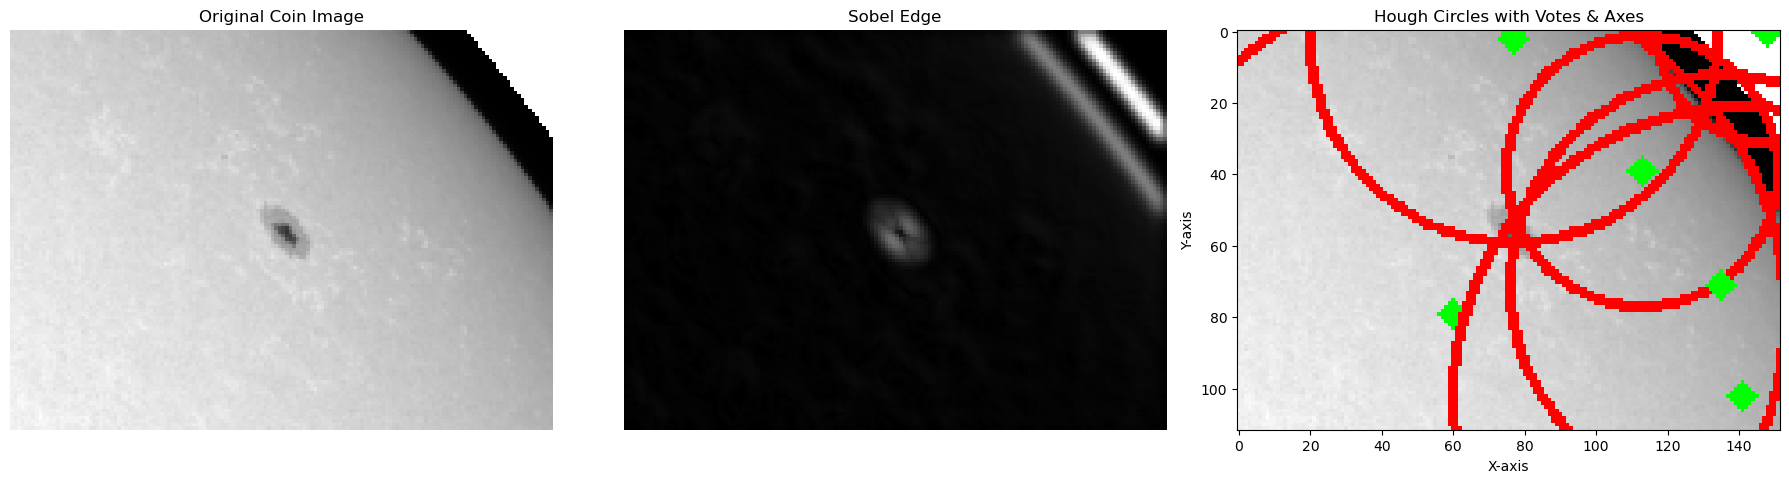

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks

# --- Load and Prepare the Image ---
solar_image = Image.open("../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png").convert("L")
solar_image_array = np.array(solar_image, dtype=np.uint8)

blurred = cv2.GaussianBlur(solar_image_array, (9, 9), 2)

# --- Built-in Sobel Edge Detection ---
# Compute the Sobel gradients in X and Y directions
sobel_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

# Convert gradients to absolute values and then to uint8
abs_sobel_x = cv2.convertScaleAbs(sobel_x)
abs_sobel_y = cv2.convertScaleAbs(sobel_y)

# Combine the two gradients to get the overall edge image
edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)

# Threshold the edge image to create a binary image
_, edge_thresh = cv2.threshold(edge_image, 50, 255, cv2.THRESH_BINARY)

# --- Hough Circle Detection using scikit-image ---
# Define the range of radii to search for
radii = np.arange(20, 101, 1)  # From 20 to 100, step of 1

# Compute the Hough Transform for the specified radii
hough_res = hough_circle(edge_thresh, radii, normalize=False)

# Find the peaks (detected circles) in the Hough accumulator
accums, cx, cy, detected_radii = hough_circle_peaks(hough_res, radii,
                                                    min_xdistance=30, min_ydistance=30,
                                                    threshold=0.4 * np.max(hough_res),
                                                    total_num_peaks=10)

# Print the votes and radius for each detected circle
for accum, x, y, r in zip(accums, cx, cy, detected_radii):
    print(f"Circle at ({x}, {y}) with radius {r} has {accum} votes")

# --- Draw the Detected Circles ---
# Create a color copy of the original image for drawing
solar_image_color = cv2.cvtColor(solar_image_array, cv2.COLOR_GRAY2BGR)

# Draw each detected circle and its center
for x, y, r in zip(cx, cy, detected_radii):
    cv2.circle(solar_image_color, (x, y), int(r), (0, 0, 255), 2)  # Red circle perimeter
    cv2.circle(solar_image_color, (x, y), 2, (0, 255, 0), 3)       # Green center point

# --- Display the Results ---
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Original image with axes turned off for clarity
axs[0].imshow(solar_image_array, cmap="gray")
axs[0].set_title("Original Coin Image")
axs[0].axis("off")

# Edge image with axes turned off
axs[1].imshow(edge_image, cmap="gray")
axs[1].set_title("Sobel Edge")
axs[1].axis("off")

# Circle detected image with x and y axes shown
axs[2].imshow(cv2.cvtColor(solar_image_color, cv2.COLOR_BGR2RGB))
axs[2].set_title("Hough Circles with Votes & Axes")
# Enable axis to show coordinate ticks
axs[2].axis("on")
axs[2].set_xlabel("X-axis")
axs[2].set_ylabel("Y-axis")

plt.tight_layout()
plt.show()
